In [1]:
# Install HermesPy and its dependencies in the current kernel
# When running on Colabs, a restart of the runtime is required afterwards

import sys
!{sys.executable} -m pip install --quiet hermespy

Implementing Channels
=====================

Wireless propagation channels are a core concept in the physical layer modeling of communication and sensing systems.
In essence, they describe the behaviour of electromagnetic waves during their propagation between devices capable of transmitting electromagnetic radiation, receiving electromagnetic radation, or both.
Within Hermes' API, channels are addressed by the [Channel Module](../api/channel.rst), with each implemented channel model inheriting from a common [Channel](../api/channel.channel.Channel.rst) base class.

Adding a new channel model to the set of provided implementations is rather straightfoward.
On the most fundamental level, each channel model class is expected to provide only a [realize](../api/channel.channel.Channel.rst#hermespy.channel.channel.Channel.realization) method generating a [realization](../api/channel.channel.ChannelRealization.rst#hermespy.channel.channel.ChannelRealization) of the channel's random variables and impulse response.
To demonstrate the API workflow, we will implement a basic channel only introducing a random phase shift to the propagated waveform, no time of flight delays or multiple antenna scenarios are considered:

In [2]:
from __future__ import annotations
from typing import Any, Mapping, Type

import numpy as np
from h5py import Group

from hermespy.core import ChannelStateInformation, ChannelStateFormat, Device, Signal
from hermespy.channel import Channel, ChannelRealization, InterpolationMode


class PhaseShiftChannelRealization(ChannelRealization):

    def __init__(
        self,
        alpha_device: Device,
        beta_device: Device,
        gain: float,
        phase_shift: float,
    ) -> None:

        ChannelRealization.__init__(self, alpha_device, beta_device, gain)
        self.__phase_shift = phase_shift

    def _propagate(
        self,
        signal: Signal,
        transmitter: Device,
        receiver: Device,
        interpolation: InterpolationMode,
     ) -> Signal:

        shifted_samples = signal[:, :] * np.exp(1j * self.__phase_shift)
        return signal.from_ndarray(shifted_samples)

    def state(
        self,
        transmitter: Device,
        receiver: Device,
        delay: float,
        sampling_rate: float,
        num_samples: int,
        max_num_taps: int,
    ) -> ChannelStateInformation:
        
        state = np.sqrt(self.gain) * np.exp(1j * self.__phase_shift) * np.ones((receiver.antennas.num_receive_antennas, transmitter.antennas.num_transmit_antennas, num_samples, 1), dtype=complex)
        return ChannelStateInformation(ChannelStateFormat.IMPULSE_RESPONSE, state)

    def to_HDF(self, group: Group) -> None:
        
        ChannelRealization.to_HDF(self, group)
        group.attrs["phase_shift"] = self.__phase_shift
        
    @classmethod
    def _parameters_from_HDF(cls: Type[PhaseShiftChannelRealization], group: Group) -> Mapping[str, Any]:
        
        parameters = ChannelRealization._parameters_from_HDF(group)
        parameters["phase_shift"] = group.attrs["phase_shift"]


class PhaseShiftChannel(Channel[PhaseShiftChannelRealization]):
    
    def _realize(self) -> PhaseShiftChannelRealization:
            
        phase_shift = np.exp(2j * self._rng.normal(0, np.pi))        
        return PhaseShiftChannelRealization(self.alpha_device, self.beta_device, self.gain, phase_shift)
    
    def recall_realization(self, group: Group) -> PhaseShiftChannelRealization:
        
        return PhaseShiftChannelRealization.From_HDF(group, self.alpha_device, self.beta_device)

During simulation runtime, the impulse response routine will be called for each channel propagation over a single link configured to the newly created *PhaseShiftChannel*.
It is expected to return a four-dimensional numpy tensor modeling a channel impulse sampled *num_samples* times at frequency *sampling_rate*.
The first tensor dimension denotes the number of time-domain impulse response samples, the second and third dimension the number of transmit and receive antennas, and the fourth dimension the impulse response of each sample instance, respectively.

We can now plug the newly generated channel model into a simulation scenario evaluating an [OFDM waveform](../api/modem.waveforms.orthogonal.ofdm.OFDMWaveform.rst) with access to ideal channel state information, equalizing the channel by [zero forcing](../api/modem.waveform.ZeroForcingChannelEqualization.rst):

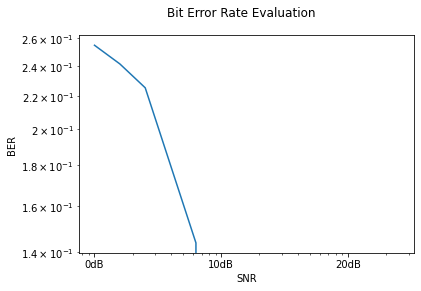

In [3]:
import matplotlib.pyplot as plt

from hermespy.core import dB, ConsoleMode
from hermespy.simulation import Simulation, OFDMIdealChannelEstimation
from hermespy.modem import BitErrorEvaluator, DuplexModem, ElementType, GridElement, GridResource, SymbolSection, OFDMWaveform, ZeroForcingChannelEqualization


# Create a new Monte Carlo simulation
simulation = Simulation(console_mode=ConsoleMode.SILENT)

# Add a single device, operated by a communication modem
operator = DuplexModem()
operator.device = simulation.new_device()
operator.reference = operator.device

# Configure an OFDM waveform with a frame consisting of a single symbol section
operator.waveform = OFDMWaveform(grid_resources=[GridResource(elements=[GridElement(ElementType.DATA, 1024)])],
                                 grid_structure=[SymbolSection(pattern=[0])])

# Add channel estimation and equalization routines
operator.waveform.channel_estimation = OFDMIdealChannelEstimation(operator.device, operator.device)
operator.waveform.channel_equalization = ZeroForcingChannelEqualization()

# Configure our newly implemented channel model
simulation.scenario.set_channel(operator.device, operator.device, PhaseShiftChannel())

# Configure a parameter sweep over the receiver SNR, effectively simulating an AWGN channel
simulation.new_dimension('noise_level', dB(0, 2, 4, 8, 16, 24), operator.device)

# Evaluate the BER
simulation.add_evaluator(BitErrorEvaluator(operator, operator))

# Configure the number of Monte Carlo samples per SNR point
simulation.num_samples = 1000

# Run the simulation and plot the results
result = simulation.run()
result.plot()
plt.show()

We can highlight the channel effect by disabling the zero-forcing channel equalization routine for the configured OFDM waveform.

In this case, the communication bit error rate should roughly approximate $\tfrac{1}{2}$, indicating that no information is exchanged and the bits are esentially random at the receiver.

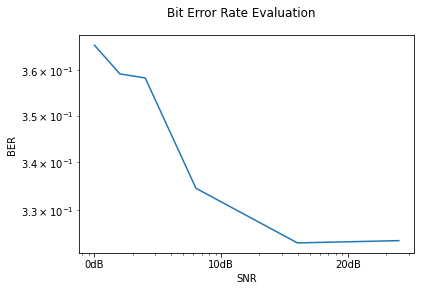

In [4]:
from hermespy.modem import ChannelEqualization

# Disable channel equalization by replacing the ZF routine with the default stub
operator.waveform.channel_equalization = ChannelEqualization()

# Run the simulation and plot the results
result = simulation.run()
result.plot()
plt.show()